# Capstone Project - The Battle of Neighborhoods

### Applied Data Science Capstone by IBM/Coursera

This Jupyter Notebook contains the capstone project for the *Coursera* [IBM Data Science Specialization](https://www.coursera.org/specializations/ibm-data-science).

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
    * [Exploratory Analyses](#explore)    
    * [Main Analysis](#main_analysis)
* [Discussion](#discussion)
* [Conclusion](#conclusion)



## Introduction/Business Problem <a name="introduction"></a>

According to [the statistical office of the City of Zurich](https://www.stadt-zuerich.ch/content/dam/stzh/prd/Deutsch/Statistik/Publikationsdatenbank/jahrbuch/2017/Tabellen/T_JB_2017_10_2.xlsx), there are currently around 2200 restaurants listed in the City of Zurich. With around 400'000 inhabitants, this means that there is one restaurant for every 200 citizens, or put differently, this is comparable to having five restaurants in a small village of 1000 inhabitants. Unsurprisingly, it is estimated that around 62% of restaurants in Zurich, and particularly small ones, are in the red ([NZZ](https://www.nzz.ch/wirtschaft/jedes-zweite-restaurant-schreibt-verlust-1.18300150)). In order to be able to cover personnel and rental costs, stakeholders planning to open a restaurant in Zurich will have to make an educated decision on suitable locations that 1) attract a sufficient number of guests and 2) have affordable rental charges.

The aim of this project is to characterise the different neighborhoods in Zurich based on whether or not they may be a promising location for a new restaurant to be opened. The following aspects will be taken into account in the analysis:

* **The number of already existing restaurants in the vicinity**, which should be as low as possible in order to minimize the number of competitors.
* **The number of "friendly" businesses in the vicinity**, such as shopping facilities or bars, which increase the number of potential customers in the area.
* **The average rental prices in the area**, which should be as low as possible.

I will use machine learning to distinguish areas that meet the above-mentioned criteria from those that do not, and will provide a list of the most promising three areas as well as their scoring in terms of the selection criteria for stakeholders to make a final decision.


## Data <a name="data"></a>

The following data sources will be used for this analysis:

* There are 12 districts in Zurich ("Kreis"). Neighborhoods will be defined as sub-districts, of which there are 34 in Zurich (2-4 per district). The list of neighborhoods is provided by the statistical office of the City of Zurich (see [here](https://www.stadt-zuerich.ch/content/dam/stzh/prd/Deutsch/Statistik/Themen/Bevoelkerung/BEV390T3903_Bevoelkerung-nach-Alter-Stadtkreis-Stadtquartier.xlsx)).
* The location data on restaurants in Zurich will be extracted via the [Foursquare.com](www.foursquare.com) API, which, among others, provides information on the type of venues found in places all over the world, including restaurants, shopping facilities and entertainment venues. 
* Information on the average rental costs for commercial spaces per district are provided by the statistical office of the City of Zurich (see [here](https://www.stadt-zuerich.ch/content/dam/stzh/prd/Deutsch/Statistik/Themen/Bauen-Wohnen/Leerflaechen-nach-Nutzungsart-und-Quartier_Mietpreise-leer-stehender-Buero-Praxisflaechen.xlsx)). The numbers refer to Swiss Francs (CHF) per m<sup>2</sup> .
* Geospatial information (i.e. coordinates) of each neighborhood will be retrieved via reverse geocoding using the [geopy package](https://pypi.org/project/geopy/).





### Load district names and average office rent per district


In [42]:
# Plot figures in the center
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: left;
}
</style>
"""))

# Load required packages
import pandas as pd

# Load data from file
df = pd.read_csv("Zurich_df.csv") # load from file
df.head()

Kreis     Quartier  Miete
0  Kreis 1      Rathaus  540.0
1  Kreis 1  Hochschulen  540.0
2  Kreis 1    Lindenhof  540.0
3  Kreis 1         City  540.0
4  Kreis 2  Wollishofen  510.0

### Add geospatial data from geopy

In [43]:
# Load packages
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter

# Prepare geolocator
geolocator = Nominatim(user_agent="zurich_person") # define user
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Make address into a string for geocode to find
df['address'] = df['Quartier'] + ", " + df['Kreis'] + ", Zurich, Switzerland"

# Locate all places
df['location'] = df['address'].apply(geocode)

# Extract longitude and latitude
df['lng'] = df['location'].apply(lambda x: x.longitude)
df['lat'] = df['location'].apply(lambda x: x.latitude)

# Clean up
df.drop(['address', 'location'], axis = 1, inplace = True)

In [44]:
# inspect dataframe
df.head()

Kreis     Quartier  Miete       lng        lat
0  Kreis 1      Rathaus  540.0  8.544311  47.372649
1  Kreis 1  Hochschulen  540.0  8.548613  47.373846
2  Kreis 1    Lindenhof  540.0  8.540799  47.372996
3  Kreis 1         City  540.0  8.535346  47.372943
4  Kreis 2  Wollishofen  510.0  8.530708  47.342427

### Plot all neighborhoods in Zurich

In [45]:
# get center coordinates of Zurich
address = 'Zurich Hauptbahnhof, Zurich, Switzerland'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Zurich's coordinates are: ", longitude, latitude)

Zurich's coordinates are:  8.5393635 47.3781008


In [46]:
# Load package for maps
import folium # plotting library

# create map
f = folium.Figure(width = 800, height = 600)
neigh_map = folium.Map(location = [latitude, longitude], zoom_start = 12).add_to(f)

for lat, lng, label in zip(df.lat, df.lng, df.Quartier):
    folium.CircleMarker(
        [lat, lng],
        radius = 7,
        color = 'darkblue',
        popup = label,
        fill = True,
        fill_color = 'greenyellow',
        fill_opacity = 0.5
    
    ).add_to(neigh_map)

neigh_map

### Add information on venues from Foursquare

Let us load information on all venues we can find in Zurich's neighborhoods on Foursquare.

In [47]:
# Prepare information for API access
import requests # library to handle requests
from pandas import json_normalize

CLIENT_ID = 'TOPVCHKEI1GQK4T4IEL512EZNEAJT3MWXXUVGI12NL0CMIMI' # Foursquare ID
CLIENT_SECRET = '0HRUKCRKEKC3NUEY3LTIJSMT5KOCPJZEGU1ZVZ2Q5B1EZTRK' # Foursquare Secret
VERSION = '20200423' # Foursquare API version
radius = 1000 # meters from center
intent = 'browse'
limit = 2000

# Provide information on where to look for venues
districts = df['Kreis']
neighbs = df['Quartier']
rents = df['Miete']
longitudes = df['lng']
latitudes = df['lat']

In [48]:
# function that extracts the category of the venue (because sometimes it is empty)
def get_category_type(item):
    categories_list = item['categories']
        
    if len(categories_list) == 0:
        return "unknown"
    else:
        return categories_list[0]['name']

In [49]:
# Loop through all districts and add venues for each district
venues_list=[]

for dist, neigh, rent, lat, lng in zip(districts, neighbs, rents, latitudes, longitudes):
    
    # create API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&intent={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        intent,
        limit)
    
    # make the GET request
    results = requests.get(url).json()['response']['venues']
    
    # retrieve relevant information from results into a list
    venues_list.append([(
        dist,
        neigh,
        rent, 
        lat, 
        lng, 
        v['name'], 
        v['location']['lat'], 
        v['location']['lng'],  
        get_category_type(v)) for v in results])
    
# convert list to dataframe and change column names
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['District',
                         'Neighborhood',
                         'Neighborhood Rent',
                         'Neighborhood Latitude', 
                         'Neighborhood Longitude', 
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

Now we have downloaded all the information from Foursquare, but it still looks a bit messy. Some of the venues are not marked with a category and some are too close to several neighborhoods, so they appear in more than one neighborhood. Let us clean up.

### Clean up
1. Remove venues with unknown category
2. Remove venues that appear in more than one neighborhood (because the two are too close).

In [50]:
# remove venues with unknown category
final_df = nearby_venues[nearby_venues['Venue Category'] != 'unknown']

# find duplicates based on venue latitude and longitude
duplicates = final_df[final_df[['Venue Latitude', 'Venue Longitude']].duplicated(keep = False)].sort_values('Venue')

# new dataframe that will only include the venues that will be kept
no_duplicates = duplicates.copy()

In [51]:
# write a function that marks the closest neighborhood for each venue
from scipy import spatial # for finding closest coordinates
import numpy as np

def f(x):

    # define venue coordinates
    venue_lat = x['Venue Latitude'].unique()[0]
    venue_lng = x['Venue Longitude'].unique()[0]

    # define coordinates of all competing neighborhoods
    coords_list = [tuple(x) for x in x[['Neighborhood Latitude', 'Neighborhood Longitude']].to_numpy()]

    # find the closest coordinate among neighborhoods to venue
    tree = spatial.KDTree(coords_list)
    best_idx = tree.query([(venue_lat, venue_lng)])[1][0]

    # array of which row to keep
    keep = np.zeros(len(coords_list))
    keep[best_idx] = 1
    
    # make a column to mark which neighborhood we are going to keep
    x['Keep'] = keep
    return x

In [52]:
# data frame where only closest neighborhoods are marked (see column "Keep")
dropDF = no_duplicates.groupby(['Venue Latitude', 'Venue Longitude']).apply(f)
dropDF.head()                                                                                                                             

District          Neighborhood  Neighborhood Rent  \
3538  Kreis 12               Saatlen              272.5   
3656  Kreis 12  Schwamendingen-Mitte              272.5   
2441   Kreis 8               Seefeld              415.0   
2492   Kreis 8            Muehlebach              415.0   
3603  Kreis 12               Saatlen              272.5   

      Neighborhood Latitude  Neighborhood Longitude            Venue  \
3538              47.412637                8.565912      4USource AG   
3656              47.404437                8.568326      4USource AG   
2441              47.357783                8.551074  Alderstrasse 33   
2492              47.360772                8.554362  Alderstrasse 33   
3603              47.412637                8.565912             Amag   

      Venue Latitude  Venue Longitude Venue Category  Keep  
3538       47.408322         8.568231         Office   0.0  
3656       47.408322         8.568231         Office   1.0  
2441       47.359559         8.552708     Strip Club   0.0  
2492       47.359559         8.552708     Strip Club   1.0  
3603       47.407401         8.567241    Gas Station   0.0

In [53]:
# remove rows where Keep == 0
dropDF = dropDF.loc[dropDF['Keep'] == 0]
dropDF.drop('Keep', axis = 1, inplace = True)

# remove all rows in final_df that are identical with the dropDF (because they should be dropped)
final_df = final_df.loc[final_df.index.difference(dropDF.index), ]

final_df.head()

District Neighborhood  Neighborhood Rent  Neighborhood Latitude  \
0  Kreis 1      Rathaus              540.0              47.372649   
1  Kreis 1      Rathaus              540.0              47.372649   
2  Kreis 1      Rathaus              540.0              47.372649   
3  Kreis 1      Rathaus              540.0              47.372649   
4  Kreis 1      Rathaus              540.0              47.372649   

   Neighborhood Longitude                    Venue  Venue Latitude  \
0                8.544311  Oliver Twist Pub Zürich       47.372280   
1                8.544311                  Äss-Bar       47.372561   
2                8.544311          Restaurant 1001       47.372974   
3                8.544311                   Zürich       47.373158   
4                8.544311             Café Henrici       47.372516   

   Venue Longitude      Venue Category  
0         8.544270          Sports Bar  
1         8.543693              Bakery  
2         8.543783  Falafel Restaurant  
3         8.544117               Motel  
4         8.543686                Café

Now there are no more duplicate venues in the dataframe.

This is the final dataframe. Let's go!

## Methodology <a name="methodology"></a>

After having preprocessed the data required for the upcoming analysis, the following steps will be performed on the data: 

#### 1. Exploratory Analyses

First, we will take a look at the individual parameters that are going to decide whether or not a neighborhood is suitable as a new restaurant spot or not. To do so, I will investigate **how many restaurants there are in Zurich** and **how they are spread across the city**. 

In a second step, I will **compare neighborhoods on the basis of their average rental costs** and check **whether there is a relationship between the rental price and the popularity of neighborhoods for restaurants**.

Third, I will examine the **number of friendly businesses** in each neighborhood and **compare the number of friendly businesses in each neighborhood with the number of friendly businesses**.

Based on this exploratory information, we can then proceed to the main analysis, in which all of these aspects will be combined.

#### 2. Main Analyses

The main analysis will consist of two parts: 

First, I will rank each neighborhood by their number of competitors, friendly businesses and average rent and calculate an **overall (mean) score that describes how favourable the conditions in a given neighborhood are**. This overall score can then be used directly as a measure of whether (1) or not (0) a given neighborhood is overall suitable. 

In a second step, I will **cluster the neighborhoods of Zurich** in order to find similarities between them based on the three criteria. This approach is more nuanced than considering the overall mean, as neighborhoods can be very favourable regarding two criteria but unfavourable regarding the third. The cluster analysis will tell us which neighborhoods are similar and how they load on each of the assessment criteria.

Wherever possible, visualization of a given analysis will be provided.

## Results <a name="results"></a>

### Exploratory Analyses <a name="explore"></a>

#### How many food places (including cafés, restaurants and other food places) are registered on Foursquare for the city of Zurich?

In [54]:
restaurantsOnly = final_df[final_df['Venue Category'].str.contains('restaurant|food|cafe|café', case = False)]
n= len(restaurantsOnly)
print('Foursquare found {} restaurants in Zurich.'.format(n))

Foursquare found 472 restaurants in Zurich.


As per the statistical office of the City of Zurich, there should be more than 2000, but not all of them are registered on Foursquare (see above). This is problematic, because it means that our analysis likely will only include the most popular/ most visited ones, so in a real-case scenario, we would change to a different location information provider that includes a more comprehensive list of venues in Zurich (e.g. Yelp or Trip-Advisor). However, for this task, we will stick with Foursquare.

#### Which areas are very dense in restaurants?

Let us take a look by plotting all restaurants and color them by neighborhoods. You can click on any of the circle markers to get information about the district and the respective restaurant.

In [55]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# plot neighborhood centers together with restaurants
f = folium.Figure(width = 800, height = 600)
neigh_map = folium.Map(location = [latitude, longitude], zoom_start = 13).add_to(f)

neighGroup = restaurantsOnly.groupby('Neighborhood').ngroup()
colors_array = cm.plasma(np.linspace(0, 1, len(restaurantsOnly['Neighborhood'].unique())))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, group, neigh, name in zip(restaurantsOnly['Venue Latitude'], restaurantsOnly['Venue Longitude'], neighGroup, 
                                        restaurantsOnly['Neighborhood'],restaurantsOnly['Venue']):
        folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = folium.Popup(neigh + '<br>' + name, min_width = 100, max_width = 500),
        color = rainbow[group],
        color_opacity = 0.5,
        fill = True,
        fill_color = rainbow[group],
        fill_opacity = 0.2
    
    ).add_to(neigh_map)

neigh_map

As the above map shows, especially in the city center, restaurants are clustered densely around specific areas, so opening another restaurant within these areas would mean a high number of competitors. Let us take a look at how restaurants are distributed across neighborhoods.

#### Which neighborhoods have a low number of restaurants?

In [56]:
ans = restaurantsOnly.groupby('Neighborhood').size().sort_values(ascending = True)[0:15]
print("The top 15 neighborhoods with the lowest number of restaurants are:")
print(ans)

The top 15 neighborhoods with the lowest number of restaurants are:
Neighborhood
Hochschulen     4
Hirzenbach      5
Seefeld         5
Affoltern       6
Friesenberg     6
Muehlebach      8
Fluntern        8
Weinegg         9
Lindenhof      10
Witikon        10
Saatlen        10
Hirslanden     11
Escher Wyss    11
Albisrieden    11
Oberstrass     11
dtype: int64


These are the areas with a very low number in restaurants, and may therefore be a suitable choice for stakeholders. However, there are other factors that need to be taken into account, too, such as the average rent for commercial space and the number of "friendly" venues, which I will explore next.

#### Where are rental costs highest?

I will plot the same restaurants as above, but this time, color coding will be used to rank districts from most (red) to least expensive (green). Since information on rental costs is only available for districts (and not neighborhoods), the ranking will also be done for districts.

You can click on any of the circle markers to get information about the district and the respective restaurant.

In [57]:
# prepare data
restaurantsOnly = restaurantsOnly.sort_values(by = 'Neighborhood Rent', ascending = True)

# plot neighborhood centers together with restaurants
f = folium.Figure(width = 800, height = 600)
neigh_map = folium.Map(location = [latitude, longitude], zoom_start = 13).add_to(f)

neighGroup = restaurantsOnly.groupby('District').ngroup()
colors_array = cm.autumn(np.linspace(0, 1, len(restaurantsOnly['District'].unique())))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, group, distr, name in zip(restaurantsOnly['Venue Latitude'], restaurantsOnly['Venue Longitude'], neighGroup, 
                                        restaurantsOnly['District'],restaurantsOnly['Venue']):
        folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = folium.Popup(distr + '<br>' + name, min_width = 100, max_width = 500),
        color = rainbow[group],
        color_opacity = 0.5,
        fill = True,
        fill_color = rainbow[group],
        fill_opacity = 0.2
    
    ).add_to(neigh_map)

legend_html =   '''
                <div style="position: fixed; 
                            top: 50px; right: 50px; width: 150px; height: 50px; 
                            border:2px solid grey; z-index:9999; font-size:14px;background-color:white;
                            ">&nbsp; <i class="fa fa-circle fa-1x" style="color:#ff0000;"></i>&nbsp;Most Expensive <br>
                              &nbsp; <i class="fa fa-circle fa-1x" style="color:#ffff00"></i>&nbsp;Least Expensive 
                </div>
                '''
neigh_map.get_root().html.add_child(folium.Element(legend_html))        
        
neigh_map

In [58]:
print("The districts with the lowest rents are:")
restaurantsOnly[['District', 'Neighborhood Rent']].drop_duplicates().sort_values(by = 'Neighborhood Rent')[0:5]

The districts with the lowest rents are:


District  Neighborhood Rent
2713   Kreis 9              215.0
1308   Kreis 4              230.0
3327  Kreis 11              245.0
935    Kreis 3              250.0
1458   Kreis 5              259.0

It looks as if the central neighborhoods are also the most expensive ones rent-wise, but is there a correlation between the number of restaurants in an area and the average rent for commercial spaces? 

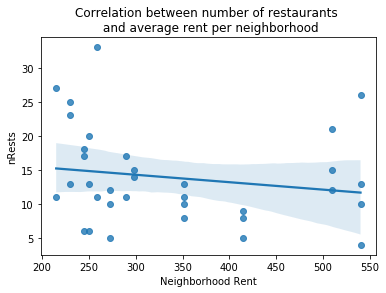

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# summarise number of restaurants in data frame
nRests = restaurantsOnly.groupby('Neighborhood').agg('count').reset_index()[['Neighborhood', 'District']]
nRests.columns = ['Neighborhood', 'nRests']

# get district, neighborhood, rent and number of restaurants into one data frame
dfCorr = pd.DataFrame({'District': df['Kreis'], 
                       'Neighborhood':df['Quartier']}) # get all districts and neighborhoods
dfCorr = dfCorr.merge(restaurantsOnly[['District', 'Neighborhood Rent']].drop_duplicates().sort_values(by = 'Neighborhood Rent'),
                     on = 'District') # add rent per district
dfCorr = dfCorr.merge(nRests, on = 'Neighborhood') # add number of restaurants per neighborhood


# plot the regression between number of restaurants and neighborhood rent

sns.regplot(x = 'Neighborhood Rent', y = 'nRests', data = dfCorr)
plt.title('Correlation between number of restaurants \n and average rent per neighborhood')
plt.show()

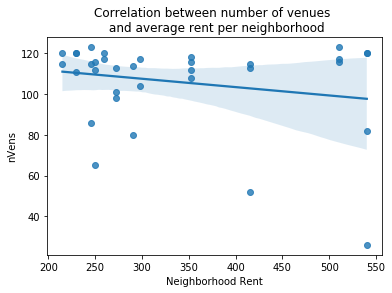

In [60]:
# summarise number of restaurants in data frame
nVens = final_df.groupby('Neighborhood').agg('count').reset_index()[['Neighborhood', 'District']]
nVens.columns = ['Neighborhood', 'nVens']

# get district, neighborhood, rent and number of venues into one data frame
dfCorr = pd.DataFrame({'District': df['Kreis'], 
                       'Neighborhood':df['Quartier']}) # get all districts and neighborhoods

dfCorr = dfCorr.merge(final_df[['District', 'Neighborhood Rent']].drop_duplicates().sort_values(by = 'Neighborhood Rent'),
                     on = 'District') # add rent per district

dfCorr = dfCorr.merge(nVens, on = 'Neighborhood') # add number of restaurants per neighborhood

# plot the regression between number of restaurants and neighborhood rent

sns.regplot(x = 'Neighborhood Rent', y = 'nVens', data = dfCorr)
plt.title('Correlation between number of venues \n and average rent per neighborhood')
plt.show()

There is no clear correlation between the two, so just because there are a lot of restaurants already (and it appears to be a popular spot), this does not mean that rents will be high.

#### Which area is densest in "friendly" venues?

As a final step in our exploratory analysis, let us look at the ratio of "friendly" venues to competitors in a given area. Friendly venues are those that attract customers for reasons other than eating (e.g. shopping, parks, bars...) and that are therefore not competitors. 

First, let us plot all restaurants against all non-restaurants.

In [61]:
# add a column in each dataframe that marks whether or not they are a restaurant
final_df['isRestaurant'] = final_df['Venue Category'].str.contains('restaurant|food|cafe|café', case = False)

# Plot restaurants (red) against non-restaurants(green)
# plot neighborhood centers together with restaurants
f = folium.Figure(width = 600, height = 400)
neigh_map = folium.Map(location = [latitude, longitude], zoom_start = 13).add_to(f)

# Series showing 1 for restaurants and 0 for others
isRest = final_df['isRestaurant'].apply(lambda x: 1 if x == True else 0)

# set colors
colors_array = ['greenyellow', 'darkred']

for lat, lng, isRest, distr, name in zip(final_df['Venue Latitude'], final_df['Venue Longitude'], isRest, 
                                        final_df['District'],final_df['Venue']):
        folium.Circle(
        [lat, lng],
        radius = 20,
        popup = distr + "\n" + name,
        color = colors_array[isRest],
        opacity = 0.3,
        fill = True,
        fill_color = colors_array[isRest],
        fill_opacity = 0.3
    
    ).add_to(neigh_map)

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 10px; left: 10px; width: 130px; height: 50px; 
                            border:2px solid grey; z-index:9999; font-size:14px;background-color:white;
                            ">&nbsp; <i class="fa fa-circle fa-1x" style="color:darkred;"></i> &nbsp; Restaurants <br>
                              &nbsp; <i class="fa fa-circle fa-1x" style="color:GreenYellow"></i>&nbsp; Others 
                </div>
                '''
neigh_map.get_root().html.add_child(folium.Element(legend_html))
neigh_map  


Well, it looks as if most restaurants are hidden within areas that have a high number of friendly businesses nearby - which makes sense. Let us take a more objective view at the ratio of friendly businesses vs. competitors.

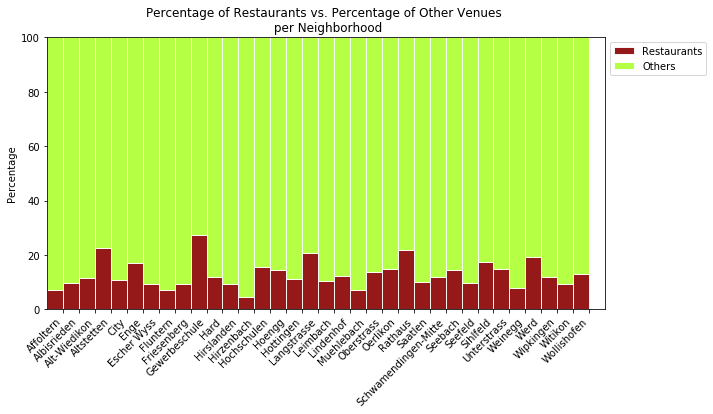

In [62]:
# Make a dataframe to compare the number of restaurants and number of friendly businesses per neighborhood
compareDF = pd.DataFrame({'District': df['Kreis'], 
                       'Neighborhood':df['Quartier'],
                         'Rent':df['Miete']}) # get all districts and neighborhoods

# get number of restaurants per neighborhood
nRests = restaurantsOnly.groupby('Neighborhood').agg('count').reset_index()[['Neighborhood', 'District']]
nRests.columns = ['Neighborhood', 'Restaurants']

# get number of other venues per neighborhood
nOthers = final_df[final_df['Venue Category'].str.contains('restaurant|food|cafe|café', case = False) == False].groupby('Neighborhood').agg('count').reset_index()[['Neighborhood', 'District']]
nOthers.columns = ['Neighborhood', 'Others']

# merge with original dataframe
compareDF = compareDF.merge(nRests, on = 'Neighborhood')
compareDF = compareDF.merge(nOthers, on = 'Neighborhood')
compareDF.drop('District', axis = 1, inplace = True)

# sort by neighborhood name to make them easier to find
compareDF = compareDF.sort_values(by = 'Neighborhood')

### Start plotting

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(len(compareDF['Restaurants']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create the total score for each neighborhood
totals = [i+j for i,j in zip(compareDF['Restaurants'], compareDF['Others'])]

# Create the percentage of the total score the number of restaurants of each neighborhood was 
rest_rel = [i / j * 100 for  i,j in zip(compareDF['Restaurants'], totals)]

# Create the percentage of the total score the number of other places of each neighborhood was 
oth_rel = [i / j * 100 for  i,j in zip(compareDF['Others'], totals)]

ax.bar(bar_l, 
       # using pre_rel data
       rest_rel, 
       # labeled 
       label='Restaurants', 
       # with alpha
       alpha=0.9, 
       # with color
       color='darkred',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using oth_rel data
       oth_rel, 
       # with rest_rel
       bottom=rest_rel, 
       # labeled 
       label='Others', 
       # with alpha
       alpha=0.9, 
       # with color
       color='greenyellow', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Set the ticks to be neighborhood names
plt.xticks(tick_pos, compareDF['Neighborhood'])
ax.set_ylabel("Percentage")
ax.set_xlabel("")

# Let the borders of the graphic
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(0, 100)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

# set title
plt.title('Percentage of Restaurants vs. Percentage of Other Venues \n per Neighborhood')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

The above plot shows that neighborhood "Gewerbeschule" has the highest number of restaurants compared to friendly businesses, while "Hirzenbach" has the lowest ratio of competitors to friendly businesses. Hence, in the upcoming analysis, we want to take this ratio into account and avoid areas where there are already a lot of restaurants and few friendly businesses.

### Main Analysis <a name="main_analysis"></a>

#### Rated Dataframe

Let us create a data frame where for each neighborhood, we get different scores for 1) rent affordability, 2) number of friendly businesses in the vicinity (i.e. in same neighborhood) and 3) number of competitors in the vicinity. 

The ranking will be done as follows: For each criterion, scores will be assigned from 0 (bad, i.e. high rent or few friendly businesses or loads of competitors) to 1 (the opposite), so that for each criterion, all neighborhoods will be compared against one another. The overall score will then be computed as the mean over the three criteria.

In [63]:
# Create data frame from districts and neighborhoods
rankDF = pd.DataFrame({'District': df['Kreis'], 
                       'Neighborhood':df['Quartier']}) # get all districts and neighborhoods

# add rent score (0 = high rent, 1 = low rent)
rankDF = rankDF.merge(restaurantsOnly[['Neighborhood', 'Neighborhood Rent']].drop_duplicates(), on = 'Neighborhood').sort_values(by = 'Neighborhood Rent', ascending = False)
rent_scores = np.linspace(0,1,len(rankDF['Neighborhood Rent'].unique()))
rankDF['Rent_score'] = rankDF.sort_values(by = 'Neighborhood Rent', ascending = False).groupby('Neighborhood Rent', sort = False).ngroup()
rankDF['Rent_score'] = rent_scores[rankDF['Rent_score']].round(2)
rankDF.drop('Neighborhood Rent', axis = 1, inplace = True)

# add score for competing businesses in the neighborhood (0 = most competitors, 1 = least competitors)
rankDF = rankDF.merge(nRests, on = 'Neighborhood')
rankDF.reset_index(inplace = True, drop = True)
rankDF['Rest_score'] = rankDF.sort_values('Restaurants', ascending = False).groupby('Restaurants', sort = False).ngroup()
rest_scores = np.linspace(0,1,len(rankDF['Restaurants'].unique()))
rankDF['Rest_score'] = rest_scores[rankDF['Rest_score']].round(2)
rankDF.drop('Restaurants', axis = 1, inplace = True)

# add score for friendly businesses (0 = few friends, 1 = loads)
rankDF = rankDF.merge(nOthers, on = 'Neighborhood')
rankDF.reset_index(inplace = True, drop = True)
rankDF['Friend_score'] = rankDF.sort_values('Others', ascending = True).groupby('Others', sort = False).ngroup()
oth_scores = np.linspace(0,1,len(rankDF['Others'].unique()))
rankDF['Friend_score'] = oth_scores[rankDF['Friend_score']].round(2)
rankDF.drop('Others', axis = 1, inplace = True)

# Add overall score
rankDF['Overall_score'] = rankDF[['Rent_score', 'Rest_score', 'Friend_score']].mean(axis = 1).round(2)

# Sort by overall score
rankDF = rankDF.sort_values('Overall_score', ascending = False)

Based on average rent, number of competitors and number of friendly businesses, Zurich's neighborhoods can be ranked as follows. The higher the overall score, the more favourable the conditions are in this area.

In [64]:
rankDF.to_csv("overallRanking.csv")
rankDF

District          Neighborhood  Rent_score  Rest_score  Friend_score  \
33   Kreis 9           Albisrieden        1.00        0.68          0.83   
18  Kreis 12            Hirzenbach        0.55        0.95          1.00   
21   Kreis 5           Escher Wyss        0.64        0.68          0.91   
31   Kreis 4                  Hard        0.91        0.58          0.61   
28  Kreis 11               Seebach        0.82        0.37          0.87   
13   Kreis 7              Fluntern        0.27        0.84          0.83   
24   Kreis 3          Alt-Wiedikon        0.73        0.58          0.65   
26  Kreis 11             Affoltern        0.82        0.89          0.22   
7    Kreis 8               Weinegg        0.18        0.79          0.91   
8    Kreis 8            Muehlebach        0.18        0.84          0.87   
27  Kreis 11              Oerlikon        0.82        0.42          0.61   
11   Kreis 7            Hirslanden        0.27        0.68          0.87   
23   Kreis 3           Friesenberg        0.73        0.89          0.09   
12   Kreis 7             Hottingen        0.27        0.58          0.87   
14  Kreis 10             Wipkingen        0.36        0.53          0.78   
29   Kreis 4                  Werd        0.91        0.21          0.57   
10   Kreis 7               Witikon        0.27        0.74          0.61   
5    Kreis 2              Leimbach        0.09        0.63          0.87   
20  Kreis 12               Saatlen        0.55        0.74          0.30   
30   Kreis 4           Langstrasse        0.91        0.16          0.48   
25   Kreis 3              Sihlfeld        0.73        0.32          0.52   
3    Kreis 1                  City        0.00        0.58          0.96   
19  Kreis 12  Schwamendingen-Mitte        0.55        0.63          0.35   
32   Kreis 9            Altstetten        1.00        0.05          0.39   
16   Kreis 6           Unterstrass        0.45        0.42          0.57   
17   Kreis 6            Oberstrass        0.45        0.68          0.13   
4    Kreis 2           Wollishofen        0.09        0.47          0.70   
15  Kreis 10                Hoengg        0.36        0.47          0.35   
9    Kreis 8               Seefeld        0.18        0.95          0.04   
6    Kreis 2                  Enge        0.09        0.26          0.74   
1    Kreis 1           Hochschulen        0.00        1.00          0.00   
22   Kreis 5         Gewerbeschule        0.64        0.00          0.26   
2    Kreis 1             Lindenhof        0.00        0.74          0.17   
0    Kreis 1               Rathaus        0.00        0.11          0.43   

    Overall_score  
33           0.84  
18           0.83  
21           0.74  
31           0.70  
28           0.69  
13           0.65  
24           0.65  
26           0.64  
7            0.63  
8            0.63  
27           0.62  
11           0.61  
23           0.57  
12           0.57  
14           0.56  
29           0.56  
10           0.54  
5            0.53  
20           0.53  
30           0.52  
25           0.52  
3            0.51  
19           0.51  
32           0.48  
16           0.48  
17           0.42  
4            0.42  
15           0.39  
9            0.39  
6            0.36  
1            0.33  
22           0.30  
2            0.30  
0            0.18

#### Plot of Neighborhoods by Overall Suitability

We can use the overall score to create a ranking of all neighborhoods and add the rank to our data frame:

In [65]:
# Prepare data
plotBestDF = df[['Quartier', 'lng','lat']]
plotBestDF.columns = ['Neighborhood', 'Neighborhood Longitude', 'Neighborhood Latitude']
plotBestDF = plotBestDF.merge(rankDF[['Neighborhood', 'Overall_score']], on = "Neighborhood")
plotBestDF = plotBestDF.sort_values(by = 'Overall_score', ascending = True)
plotBestDF['Rank'] = np.arange(0,len(plotBestDF))
plotBestDF.sort_values(by = 'Overall_score', ascending = False).head()

Neighborhood  Neighborhood Longitude  Neighborhood Latitude  Overall_score  \
24  Albisrieden                8.484657              47.374857           0.84   
33   Hirzenbach                8.587687              47.402204           0.83   
14  Escher Wyss                8.515360              47.390899           0.74   
12         Hard                8.512554              47.381743           0.70   
30      Seebach                8.548377              47.420438           0.69   

    Rank  
24    33  
33    32  
14    31  
12    30  
30    29

Now let us plot the result.

In [66]:
# Plot
# create map
f = folium.Figure(width = 700, height = 600)
neigh_map = folium.Map(location = [latitude, longitude], zoom_start = 12).add_to(f)

# Set color scheme
colors_array = cm.spring(np.linspace(0, 1, len(plotBestDF)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, label, rank in zip(plotBestDF['Neighborhood Latitude'], plotBestDF['Neighborhood Longitude'], plotBestDF['Neighborhood'], plotBestDF['Rank']):
    folium.CircleMarker(
        [lat, lng],
        radius = 9,
        color = rainbow[rank],
        popup = label,
        fill = True,
        fill_color = rainbow[rank],
        fill_opacity = 0.5
    
    ).add_to(neigh_map)

legend_html =   '''
                <div style="position: fixed; 
                            top: 50px; right: 50px; width: 150px; height: 50px; 
                            border:2px solid grey; z-index:9999; font-size:14px;background-color:white;
                            ">&nbsp; <i class="fa fa-circle fa-1x" style="color:#ffff00;"></i>&nbsp;Most Suitable <br>
                              &nbsp; <i class="fa fa-circle fa-1x" style="color:#ff00ff"></i>&nbsp;Least Suitable 
                </div>
                '''
neigh_map.get_root().html.add_child(folium.Element(legend_html))      
    
neigh_map

As the above plot shows, the least suitable neighborhoods to open a new restaurant are in the city center, that is, close to Zurich main station and the lake. At the same time, the neighborhoods "Hard" and "Wiedikon", which are also fairly central, feature almost ideal conditions. This is the result if all criteria are weighted equally.

#### Cluster Analysis

As mentioned earlier, taking the mean over all three criteria is not very informative, because it counfounds information across the three and keeps stakeholders from making informed decisions on how to weight each of the factors.

In the following, we extract the three scores for each of the neighborhoods and perform a cluster analysis on them, looking for exactly four clusters (i.e. four groups of restaurants that are similar in terms of these three criteria).

In [67]:
# load required package
from sklearn.cluster import KMeans # for K-Means Clustering

# Get relevant data
clustDF = rankDF[['Rent_score', 'Rest_score', 'Friend_score']].copy()

X = clustDF.values

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=20).fit(X)

Now each neighborhood has been assigned a cluster id of either 0, 1, 2 or 3. Let us insert the cluster ID back into the cluster dataframe and take a look.

In [68]:
clustDF.insert(0, 'Neighborhood', rankDF['Neighborhood'])
clustDF.insert(1, 'Cluster', kmeans.labels_)
clustDF.head(10)

Neighborhood  Cluster  Rent_score  Rest_score  Friend_score
33   Albisrieden        0        1.00        0.68          0.83
18    Hirzenbach        0        0.55        0.95          1.00
21   Escher Wyss        0        0.64        0.68          0.91
31          Hard        0        0.91        0.58          0.61
28       Seebach        0        0.82        0.37          0.87
13      Fluntern        1        0.27        0.84          0.83
24  Alt-Wiedikon        0        0.73        0.58          0.65
26     Affoltern        3        0.82        0.89          0.22
7        Weinegg        1        0.18        0.79          0.91
8     Muehlebach        1        0.18        0.84          0.87

Now let us examine the characteristics of each of the clusters.

In [69]:
#clustDF.groupby('Cluster').mean()
showDF = clustDF.copy().groupby('Cluster').mean()
showDF.columns = ['Rent Score', 'Competition Score', 'Friends Score']
showDF.to_csv("clusters.csv")
showDF

Rent Score  Competition Score  Friends Score
Cluster                                              
0          0.781429           0.608571       0.782857
1          0.193846           0.574615       0.770000
2          0.838000           0.148000       0.444000
3          0.404444           0.776667       0.183333

Given these clusters, we can see that restaurants can rank differently on each of the criteria. If we summarise the characteristics of each cluster, the following pattern emerges:
    
* **Cluster 0**: The perfect spot where all three conditions are above average.
* **Cluster 1**: Neighborhoods with a high number of friendly businesses and little competition, but a fairly high rent.
* **Cluster 2**: Neighborhoods with low rent, some friendly businesses but loads of competition.
* **Cluster 3**: Neighborhoods with hardly any competitors, somewhat high rent and virtually no friendly businesses.

#### Plot of Neighborhoods by Cluster

Now let us take a look how these clusters are spread around Zurich.

In [71]:
# add clusters to plotBestDF
plotBestDF.insert(5, "Cluster", clustDF['Cluster'])
plotBestDF.head()

Neighborhood  Neighborhood Longitude  Neighborhood Latitude  \
0         Rathaus                8.544311              47.372649   
2       Lindenhof                8.540799              47.372996   
13  Gewerbeschule                8.530086              47.383818   
1     Hochschulen                8.548613              47.373846   
6            Enge                8.528708              47.361789   

    Overall_score  Rank  Cluster  
0            0.18     0        1  
2            0.30     1        3  
13           0.30     2        1  
1            0.33     3        3  
6            0.36     4        1

In [74]:
# Plot
f = folium.Figure(width = 700, height = 600)
neigh_map = folium.Map(location = [latitude, longitude], zoom_start = 12).add_to(f)

# Set color scheme
colors_array = cm.jet(np.linspace(0, 1, len(plotBestDF['Cluster'].unique())))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, label, clust, nrest, nfriend, rent in zip(plotBestDF['Neighborhood Latitude'], plotBestDF['Neighborhood Longitude'], plotBestDF['Neighborhood'], plotBestDF['Cluster'],
                                                       compareDF['Restaurants'], compareDF['Others'], compareDF['Rent']):
    
    popup_text = "{}<br> Restaurants: {:,}<br> Others: {:,}<br> Rent per m<sup>2</sup>: {:,}"
    popup_text = popup_text.format(
        label,
        nrest,
        nfriend,
        rent
    
    )
    
    folium.CircleMarker(
        [lat, lng],
        radius = 9,
        color = rainbow[clust],
        popup = folium.Popup(popup_text, min_width = 100, max_width = 500),
        fill = True,
        fill_color = rainbow[clust],
        fill_opacity = 0.5
    
    ).add_to(neigh_map)

legend_html =   '''
                <div style="position: fixed; 
                            top: 50px; right: 50px; width: 100px; height: 90px; 
                            border:2px solid grey; z-index:9999; font-size:14px;background-color:white;
                            ">&nbsp; <i class="fa fa-circle fa-1x" style="color:#000080;"></i>&nbsp;Cluster 0 <br>
                            &nbsp; <i class="fa fa-circle fa-1x" style="color:#00d4ff;"></i>&nbsp;Cluster 1<br>
                            &nbsp; <i class="fa fa-circle fa-1x" style="color:#ffe600;"></i>&nbsp;Cluster 2 <br>
                              &nbsp; <i class="fa fa-circle fa-1x" style="color:#800000"></i>&nbsp;Cluster 3
                </div>
                '''
neigh_map.get_root().html.add_child(folium.Element(legend_html))      
    
neigh_map

Click on any of the neighborhoods to get details on the number of competitors, friendly businesses and rent per m<sup>2</sup> for the respective area.

If we compare the earlier map reflecting overall scores and this one, we can make the following observations: In contrast to the previous mean-based scores, the cluster means provide more nuanced information on how each criterion is met in a given cluster of neighborhoods. For example, both the neighborhoods City (left of Lindenhof) and Lindenhof were ranked as one of the least suitable ones previously, but we did not know why. Using clustering, we can see that neighborhood City belongs to the cluster with a particularly high rent, whereas Lindenhof forms part of the cluster that has almost no friendly businesses. Similar comparisons can be drawn for other neighborhoods.

## Discussion <a name="discussion"></a>

The decision to open a new restaurant, particularly in a city where 60% of restaurants are in the red, needs to be based on a number of careful considerations in order to ensure the success of its business. The *Where* is key in this process, as it will decide the number of customers that visit on a daily basis and whether that number is sufficient to pay for the rent, personnel costs and other expenses.

This analysis examined three main factors to characterise Zurich's neighborhood in terms of their suitability for new restaurants: 1) The number of competing food businesses in the neighborhood, 2) the number of other businesses that could attract potential customers and 3) the average rent for commercial space in that area. 

Visual inspection of the distribution of restaurants across the city indicated that restaurants are particularly dense in the three central neighborhoods belonging to District 1. At the same time, commercial space is most expensive in these neighborhoods, so that although there may be a lot of potential customers from other businesses, high competition and high rents may reduce the potential for revenue. 

When examining areas outside the city center, however, the story becomes a little more complex, as competition, friendly businesses and rental prices can go in opposite directions and cancel one another out. For neighborhoods that score high on all three criteria (Albisrieden, Hirzenbach and Escher Wyss) with overall scores of 0.8 out of 1.0, it is safe to assume that they did not score extremely low on any of the criteria. For lower ranking neighborhoods, however, the overall score is little informative and does not tell us whether a neighborhood scored lower on all three criteria or just on one or two.

The cluster analysis helps us identifying neighborhoods based on how similarly the score on each of the three criteria. For instance, neighborhoods in Cluster 3 feature a very low number of friendly businesses and may therefore score low on the average rating. However, a low number of businesses can mean that there are a lot of parks, hiking paths or other non-commercial spaces that attract people, so that these neighborhoods may be just as suitable as those that meet all three criteria.

Thus, while this analysis constitutes an objective characterisation of neighborhoods, it is only a starting point for stakeholders to reach their final decision, and a number of further considerations will have to be taken into account.

## Conclusion <a name="conclusion"></a>

The aim of this project was to identify and characterize suitable neighborhoods in Zurich to open a new restaurant. Based on my findings, stakeholders can make an informed choice on where it makes sense to dig deeper, make onsite visits, look for available commercial space etc. and where it does not. In addition, the cluster analysis provides insight into characteristically similar neighborhood and allows stakeholders to decide for themselves how each of the criteria matters in their business decision.

A limiting factor of the current analysis is the use of Foursquare as location information provider, as it only included 1/4 of the restaurants in Zurich, so that findings are likely not representative. Alternative options of location providers would be Yelp, Trip Advisor or similar. 

Finally, the reason why most of the restaurants in Zurich do not make any profit is often not even due to bad choice of location but due to personnel and other costs ([NZZ](https://www.nzz.ch/wirtschaft/jedes-zweite-restaurant-schreibt-verlust-1.18300150)). Therefore, the right choice of location does not guarantuee a successful business, but it certainly forms an important pillar of starting one.